### Import section

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import color
from skimage.feature import hog

In [3]:
import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# !pip install visualkeras
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# pip install opencv-python
import cv2
import os

folder_path = "ds_two"             # base/root directory

no_tumor = os.listdir(folder_path + '/no_tumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')
craniopharyngioma = os.listdir(folder_path + '/craniopharyngioma_final_1070/')

# no_tumor, glioma, meningioma, pituitary, craniopharyngioma

dataset=[]
lab=[]

In [6]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/no_tumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [7]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [8]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [9]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [10]:
for image_name in craniopharyngioma:
    image=cv2.imread(folder_path + '/craniopharyngioma_final_1070/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(4)

In [11]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(8103, 240, 240, 3) (8103,)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [13]:
import cv2
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

dataset = np.array(dataset)
lab = np.array(lab)

# Preprocess input images
dataset = preprocess_input(dataset)

# One-hot encode labels
lab_onehot = to_categorical(lab, num_classes=5)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, lab_onehot, test_size=0.2, random_state=42)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Add custom classification head
x = base_model.output
x = Flatten()(x)
x = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create callbacks for early stopping and model checkpoint

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience = 30, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = "resnet_brain.h5",
                                                      monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs= 80, batch_size = 32, validation_data=(X_test, y_test),
                   callbacks=[early_stopping, model_checkpoint])

Epoch 1/80
203/203 [==============================] - 2017s 10s/step - loss: 1.6870 - accuracy: 0.7974 - val_loss: 153.5295 - val_accuracy: 0.2949
Epoch 2/80
203/203 [==============================] - 1916s 9s/step - loss: 3.1847 - accuracy: 0.8058 - val_loss: 70.4017 - val_accuracy: 0.5170
Epoch 3/80
203/203 [==============================] - 1906s 9s/step - loss: 0.7621 - accuracy: 0.8653 - val_loss: 0.3771 - val_accuracy: 0.8717
Epoch 4/80
203/203 [==============================] - 1915s 9s/step - loss: 0.5002 - accuracy: 0.9016 - val_loss: 1.1055 - val_accuracy: 0.6663
Epoch 5/80
203/203 [==============================] - 1914s 9s/step - loss: 0.6121 - accuracy: 0.9081 - val_loss: 0.9374 - val_accuracy: 0.6835
Epoch 6/80
203/203 [==============================] - 1916s 9s/step - loss: 0.3753 - accuracy: 0.9233 - val_loss: 0.2576 - val_accuracy: 0.9087
Epoch 7/80
203/203 [==============================] - 1923s 9s/step - loss: 0.6334 - accuracy: 0.9224 - val_loss: 1.0161 - val_accur

In [14]:
model = tf.keras.models.load_model("resnet_brain.h5")

In [15]:
results = model.evaluate(X_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

51/51 [==============================] - 92s 2s/step - loss: 0.4035 - accuracy: 0.9328
The current model achieved an accuracy of 93.28%!


In [16]:
from sklearn.metrics import classification_report

# Predict labels on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Get class names
class_names = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

# Generate classification report
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Print classification report
print(classification_rep)

                   precision    recall  f1-score   support

         no_tumor       0.98      0.94      0.96       414
           glioma       0.92      0.91      0.92       335
       meningioma       0.84      0.88      0.86       339
        pituitary       0.96      0.97      0.97       345
craniopharyngioma       0.99      0.96      0.98       188

         accuracy                           0.93      1621
        macro avg       0.94      0.93      0.94      1621
     weighted avg       0.93      0.93      0.93      1621



In [18]:
from sklearn.metrics import r2_score
r2_score(y_true_classes, y_pred_classes)

0.9059808111121921

In [19]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

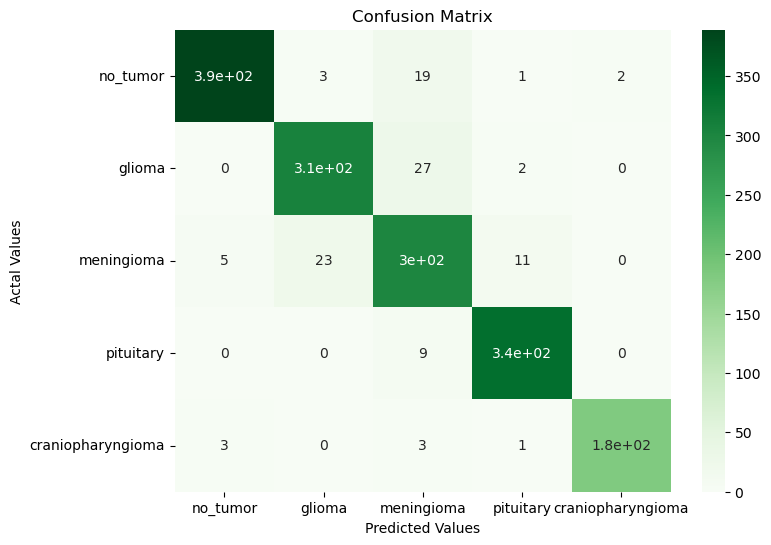

In [20]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

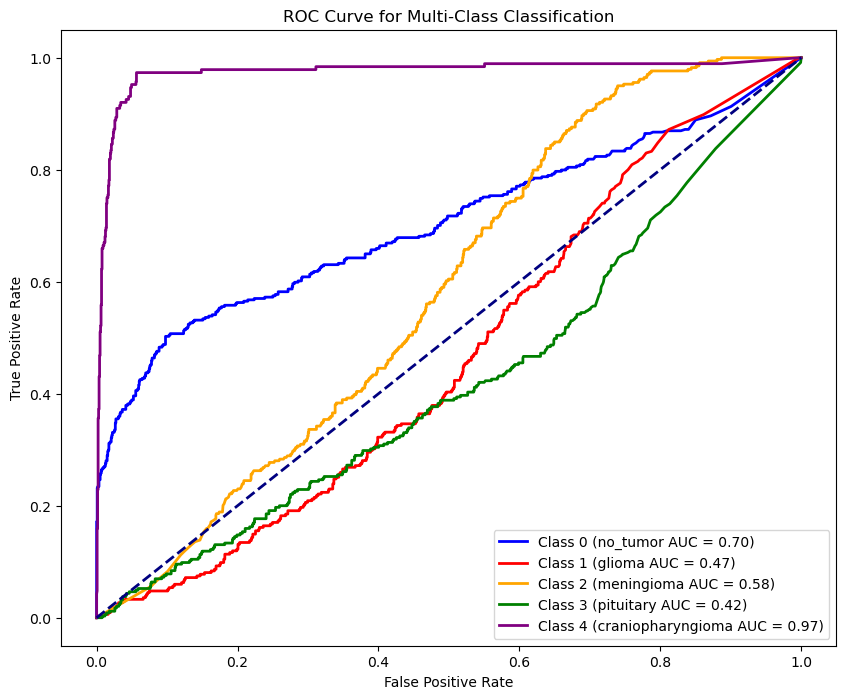

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = y_test
raw_predictions = model.predict(x_test)

y_prob = scipy.special.softmax(raw_predictions, axis=-1)

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

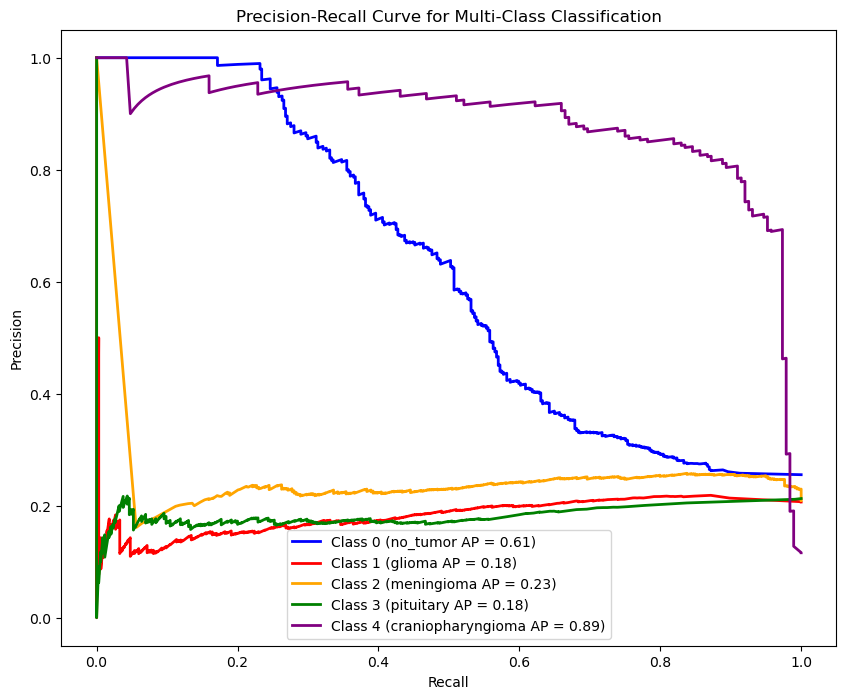

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[389   3  19   1   2]
 [  0 306  27   2   0]
 [  5  23 300  11   0]
 [  0   0   9 336   0]
 [  3   0   3   1 181]]


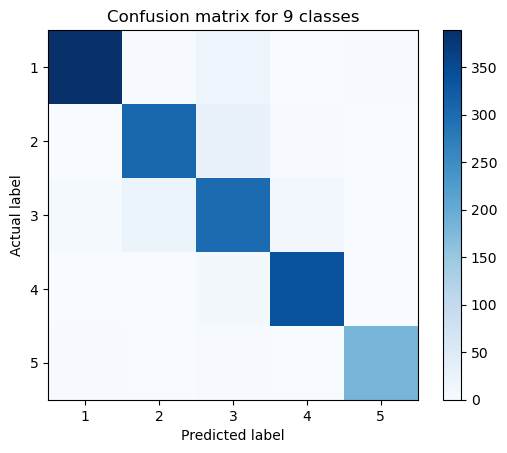

In [25]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix for 5 classes')
plt.show()

In [26]:
# Import numpy library
import numpy as np

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")


Specificity for each class:
Class 0: 0.99
Class 1: 0.97
Class 2: 0.94
Class 3: 0.98
Class 4: 1.00


In [27]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.01
Class 1: 0.02
Class 2: 0.05
Class 3: 0.01
Class 4: 0.00
FNR for each class:
Class 0: 0.06
Class 1: 0.09
Class 2: 0.12
Class 3: 0.03
Class 4: 0.04
TPR for each class:
Class 0: 0.94
Class 1: 0.91
Class 2: 0.88
Class 3: 0.97
Class 4: 0.96
TNR for each class:
Class 0: 0.99
Class 1: 0.98
Class 2: 0.95
Class 3: 0.99
Class 4: 1.00
